In [92]:
# Grafica las curvas IDT.

import warnings
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats

from matplotlib import pyplot as plt

warnings.filterwarnings( "ignore", category = pd.errors.PerformanceWarning )
warnings.filterwarnings( "ignore", category = UserWarning )

In [93]:
i = 0

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_hist_hist" ]

if i in [0, 1, 2]: t = ["día", "días"]
else: t = ["h", "horas"]

path_par = "../results/" + name[i] + "/" + name[i] + "_idf_param.nc"
path_val = "../results/" + name[i] + "/" + name[i] + "_idf_valores.nc" 
path_ret = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 

ds_par = xr.open_dataset(path_par)
ds_val = xr.open_dataset(path_val)
ds_ret = xr.open_dataset(path_ret)

# W: número de longitud.
# N: número de latitud.
# D: duración.
# T: tiempo de retorno.
# R: Rango de duración.
W = 4
N = 10
D = 4
T = 200
R = (1, 60)

In [94]:
# Utilizar información medida o calculada con distribución.
#RET = True
RET = False
if RET: ret = "valores medidos"
else: ret = "fórmula de Wenzel"

# Utilizar unidades de precipitación o de intensidad.
#PRE = True
PRE = False
pre   = "mm"
p_esp = ""
if PRE:
    p_name = "Precipitación"
    p_D = D
else:
    p_name = "Intensidad"
    pre   += "/" + t[0]
    p_esp += "   "
    p_D    = 1

LON = ds_ret["LONGITUD"].isel( LONGITUD = W ).values
LAT = ds_ret["LATITUD" ].isel( LATITUD  = N ).values

print(f"{LAT:.3f}°N, {LON:.3f}°W")

18.675°N, -100.225°W


In [95]:
# Calcula una intensidad con la fórmula de Wenzel.

# Función que nos genera una curva idT.
def idT(X, k, m, n, d):
    return ( k * X[0] ** m ) / ( X[1] + d ) ** n

param = ds_par.to_dataframe().loc[ ( ds_par.get_index("LATITUD").unique()[N],
    ds_par.get_index("LONGITUD").unique()[W] ) ]

print("Intensidad de precipitación obtenida con distribución GEV")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.1f} {t[1]}" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( idT( (T, D), *param[:-1] ) ):5.1f} {pre}" )
print( f"Error cuadrático : {param.iloc[4]:.3f}" )

Intensidad de precipitación obtenida con distribución GEV
Ubicación        : 18.675°N  -100.225°W
Duración         :   4.0 días
Tiempo de retorno:  200  años
Intensidad       :  48.5 mm/día
Error cuadrático : 566.903


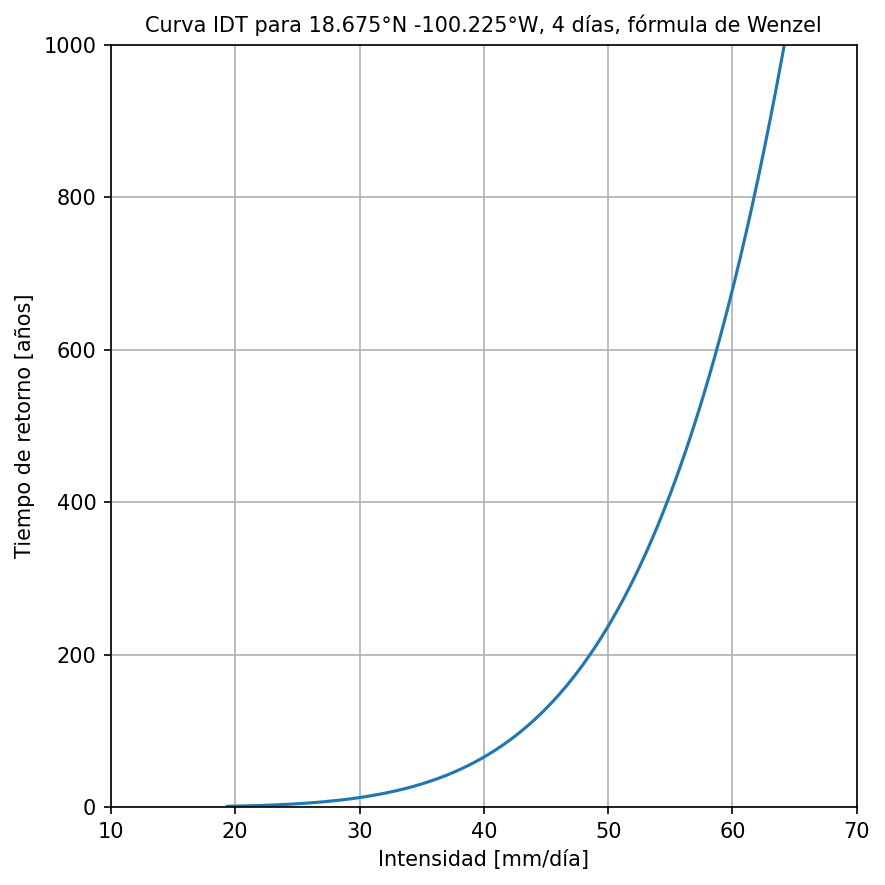

In [96]:
# Graficar una sola duración.

if RET:
    df_i_dur = ds_ret.isel( {"LONGITUD": W, "LATITUD": N}
        ).sel( {"DURACION": D} ).to_dataframe()[ ["INTENSIDAD"] ]
    # Declaramos variables.
    x = df_i_dur["INTENSIDAD"] * p_D
    y = df_i_dur.index
else:
    T_r = np.linspace(1, 1000, 1000)
    D_i = np.full_like(T_r, D) 
    P   = idT( (T_r, D_i), *param[:-1] ) 
    # Declaramos variables.
    x = P * p_D
    y = T_r

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax.plot(x, y)

# Estilo.
ax.grid(which = "both")
# Nombre de ejes.
ax.set_xlabel(f"{p_name} [{pre}]")
ax.set_ylabel("Tiempo de retorno [años]")
# Límites
if RET:
    ax.set_xlim( np.floor( df_i_dur["INTENSIDAD"].min() / 10 ) * 10,
                 np.ceil(  df_i_dur["INTENSIDAD"].max() / 10 ) * 10 )
    ax.set_ylim( 0, np.ceil( df_i_dur.index.max() / 5 ) * 5 )
else:
    ax.set_xlim( np.floor( x.min() / 10 ) * 10,
                 np.ceil(  x.max() / 10 ) * 10 )
    ax.set_ylim(0, 1000)
# Título.
ax.set_title( f"Curva IDT para {LAT:.3f}°N {LON:.3f}°W, {D} {t[1]}, {ret}",
    size = 10 )

fig.tight_layout()
plt.show()

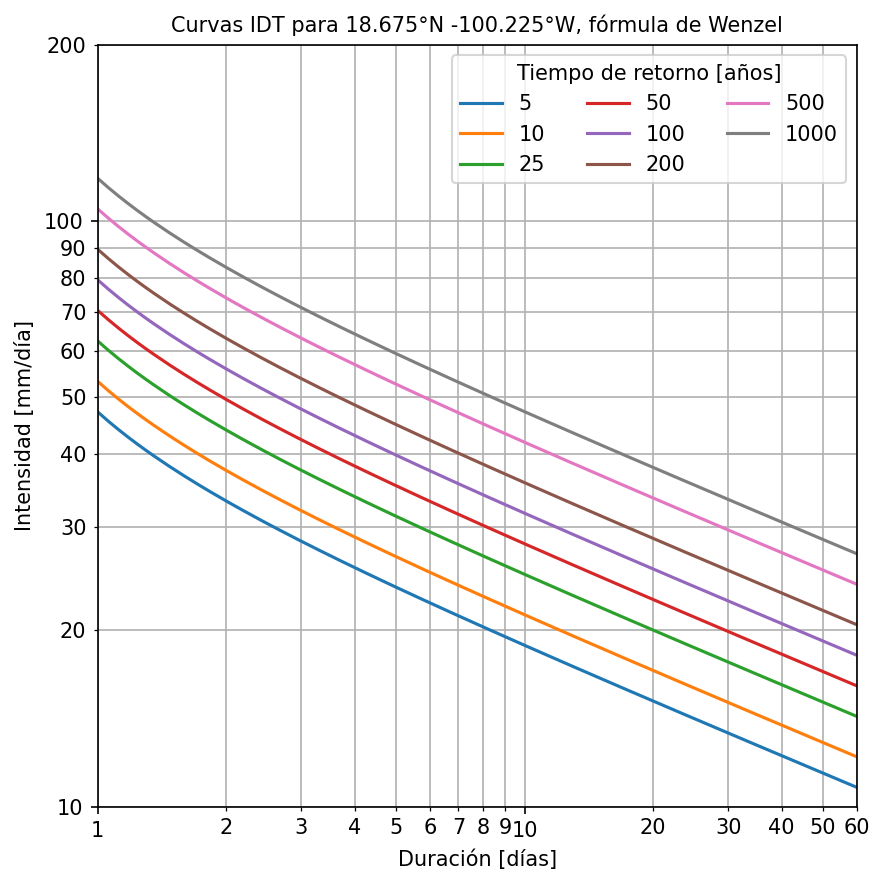

In [97]:
# Graficar todas las duraciones.

if RET: 
    df_i = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
    # Cantidad de tiempos de retorno a saltarse.
    S = 3
    df_i.columns = [f"{x:.1f}" for x in df_i.columns]
else:
    df_i = ds_val.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"].transpose()
    C = df_i.columns.shape[0]
    # Cantidad de tiempos de retorno a saltarse.
    S = 1
    # Calculamos las curvas idT.
    D_i = np.linspace(*R, 1000)
    df_i.columns = list( "A" * C )
    df_i[D_i] = None 
    df_i = df_i.iloc[:, C:]
    for i in df_i.iterrows():
        df_i.loc[ i[0] ] =  idT( (i[0], D_i), *param[:-1] )
    df_i = df_i.transpose()
    df_i.columns = df_i.columns.astype(int)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_i.loc[:, :] = ( df_i.values.transpose()
        * df_i.index.values ).transpose()
ax.plot(df_i.iloc[:, ::S])

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.xaxis.set_minor_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_minor_formatter(plt.FormatStrFormatter("%d"))
ax.grid(which = "both")
# Límites
ax.set_xlim(1, df_i.index.max())
ax.set_ylim( np.floor( df_i.values.min() ),
             np.ceil(  df_i.values.max() / 100 ) * 100 )
# Nombre de ejes.
ax.set_xlabel(f"Duración [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend(df_i.columns[::S], title = "Tiempo de retorno [años]", ncol = 3)
# Título.
ax.set_title(f"Curvas IDT para {LAT:.3f}°N {LON:.3f}°W, {ret}", size = 10)

fig.tight_layout()
plt.show()

In [98]:
df_val

,1.0,1.1,1.1,1.1,1.2,1.2,1.3,1.3,1.4,1.5,...,3.2,3.6,4.0,4.6,5.3,6.4,8.0,10.7,16.0,32.0
DURACION,,,,,,,,,,,,,,,,,,,,,
1,37.693764,38.508461,38.508461,38.508461,39.267586,39.267586,39.979122,39.979122,40.649391,41.283493,...,48.933064,50.243366,51.445175,53.083862,54.797958,57.166286,60.101070,64.152985,70.213364,82.027100
2,24.847147,25.384184,25.384184,25.384184,25.884588,25.884588,26.353621,26.353621,26.795452,27.213444,...,32.255920,33.119652,33.911865,34.992065,36.121971,37.683136,39.617702,42.288658,46.283569,54.071003
3,20.760347,21.209053,21.209053,21.209053,21.627151,21.627151,22.019039,22.019039,22.388201,22.737440,...,26.950544,27.672211,28.334124,29.236652,30.180714,31.485102,33.101475,35.333118,38.670959,45.177532
4,18.483217,18.882706,18.882706,18.882706,19.254944,19.254944,19.603848,19.603848,19.932516,20.243448,...,23.994432,24.636942,25.226252,26.029785,26.870296,28.031610,29.470688,31.457552,34.429276,40.222164
5,16.959723,17.326283,17.326283,17.326283,17.667839,17.667839,17.987984,17.987984,18.289562,18.574867,...,22.016672,22.606222,23.146957,23.884258,24.655491,25.721083,27.041544,28.864637,31.591413,36.906818
10,13.164327,13.448855,13.448855,13.448855,13.713975,13.713975,13.962476,13.962476,14.196563,14.418019,...,17.089586,17.547203,17.966927,18.539228,19.137867,19.964993,20.989948,22.405056,24.521608,28.647488
15,11.417483,11.664256,11.664256,11.664256,11.894196,11.894196,12.109721,12.109721,12.312746,12.504817,...,14.821880,15.218772,15.582802,16.079161,16.598364,17.315733,18.204683,19.432011,21.267708,24.846102
20,10.336246,10.559649,10.559649,10.559649,10.767814,10.767814,10.962928,10.962928,11.146727,11.320608,...,13.418245,13.777552,14.107107,14.556462,15.026496,15.675929,16.480696,17.591797,19.253653,22.493172
30,8.996901,9.191356,9.191356,9.191356,9.372547,9.372547,9.542379,9.542379,9.702362,9.853712,...,11.679543,11.992291,12.279144,12.670273,13.079400,13.644682,14.345169,15.312296,16.758812,19.578564


In [99]:
df_ret.iloc[:, ::S].shape[1]

31

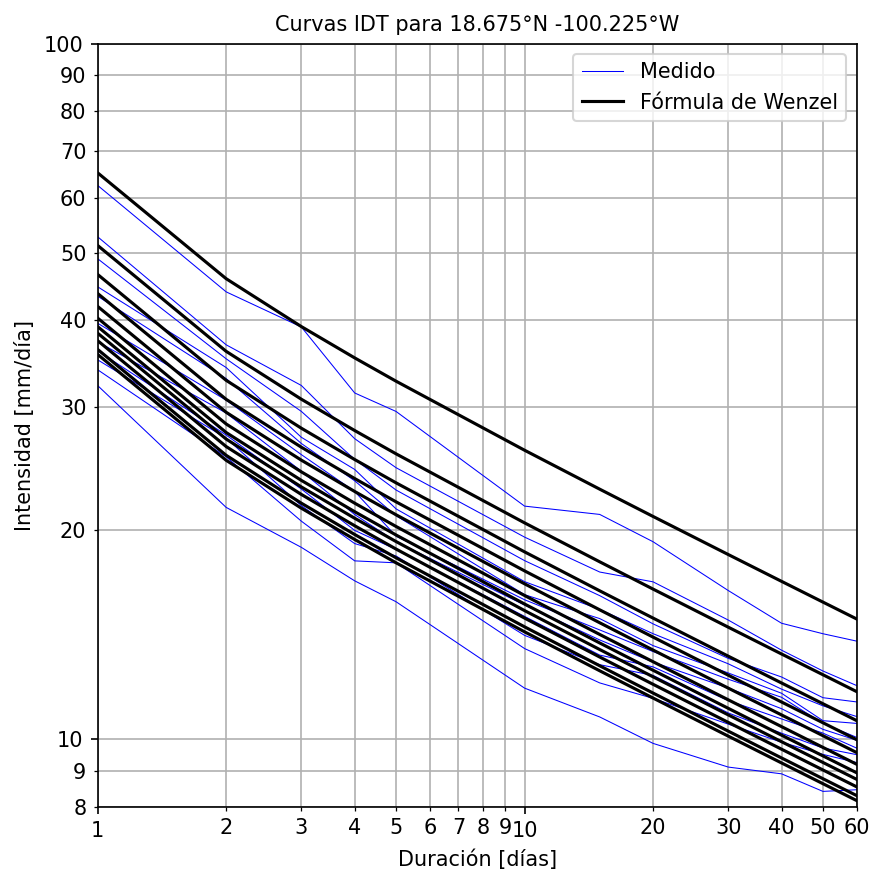

In [100]:
# Graficar todas las duraciones.


df_ret = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
    ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
# Cantidad de tiempos de retorno a saltarse.
S = 3
df_ret.columns = [f"{x:.1f}" for x in df_ret.columns]

df_val = df_ret.copy()
for i in df_val.iterrows():
    df_val.loc[ i[0] ] =  idT( ( df_val.columns.astype(float),
        i[0]), *param[:-1] )

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_ret.loc[:, :] = ( df_ret.values.transpose()
        * df_ret.index.values ).transpose()
ax.plot(df_ret.iloc[:, ::S], color = "b", linewidth = 0.5)
ax.plot(df_val.iloc[:, ::S], color = "k", linewidth = 1.5)

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.xaxis.set_minor_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_minor_formatter(plt.FormatStrFormatter("%d"))
ax.grid(which = "both")
# Límites
ax.set_xlim(1, df_ret.index.max())
ax.set_ylim( np.floor( df_ret.values.min() ),
             np.ceil(  df_ret.values.max() / 100 ) * 100 )
# Nombre de ejes.
ax.set_xlabel(f"Duración [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend( ["Medido"] + ["_"] * ( df_ret.iloc[:, ::S].shape[1] - 1 )
    + ["Fórmula de Wenzel"] )
# Título.
ax.set_title(f"Curvas IDT para {LAT:.3f}°N {LON:.3f}°W", size = 10)

fig.tight_layout()
plt.show()